# **第７章　非定常時系列の予測**

第４章から第６章では、

　　移動平均モデルMA(q)

　　　　$y_t = C + θ(L)ε_t$　,　$θ(x) 1 + Σ_{i=1}^qθ_i x^i$

　　自己回帰モデルAR(p)

　　　　$\phi(L)y_t = C + ε_t$　,　$\phi(x) = 1 - Σ_{i=1}^p \phi_i x^i$

　　自己回帰移動平均モデルARMA(p, q)

　　　　$\phi(L)y_t = C + θ(L)ε_t$

を取り上げた。

このモデルが利用するためには、

**・定常時系列**

または

**・非定常時系列**

　　→変換を適用し、拡張ディッキー・フラー(ADF)検定を用いて定常性をテスト

さらに、それぞれのモデルによる予測値として、差分を取った状態の値が返されていた。

そのため、予測値を元のデータの尺度に戻すために、逆変換する必要があった。

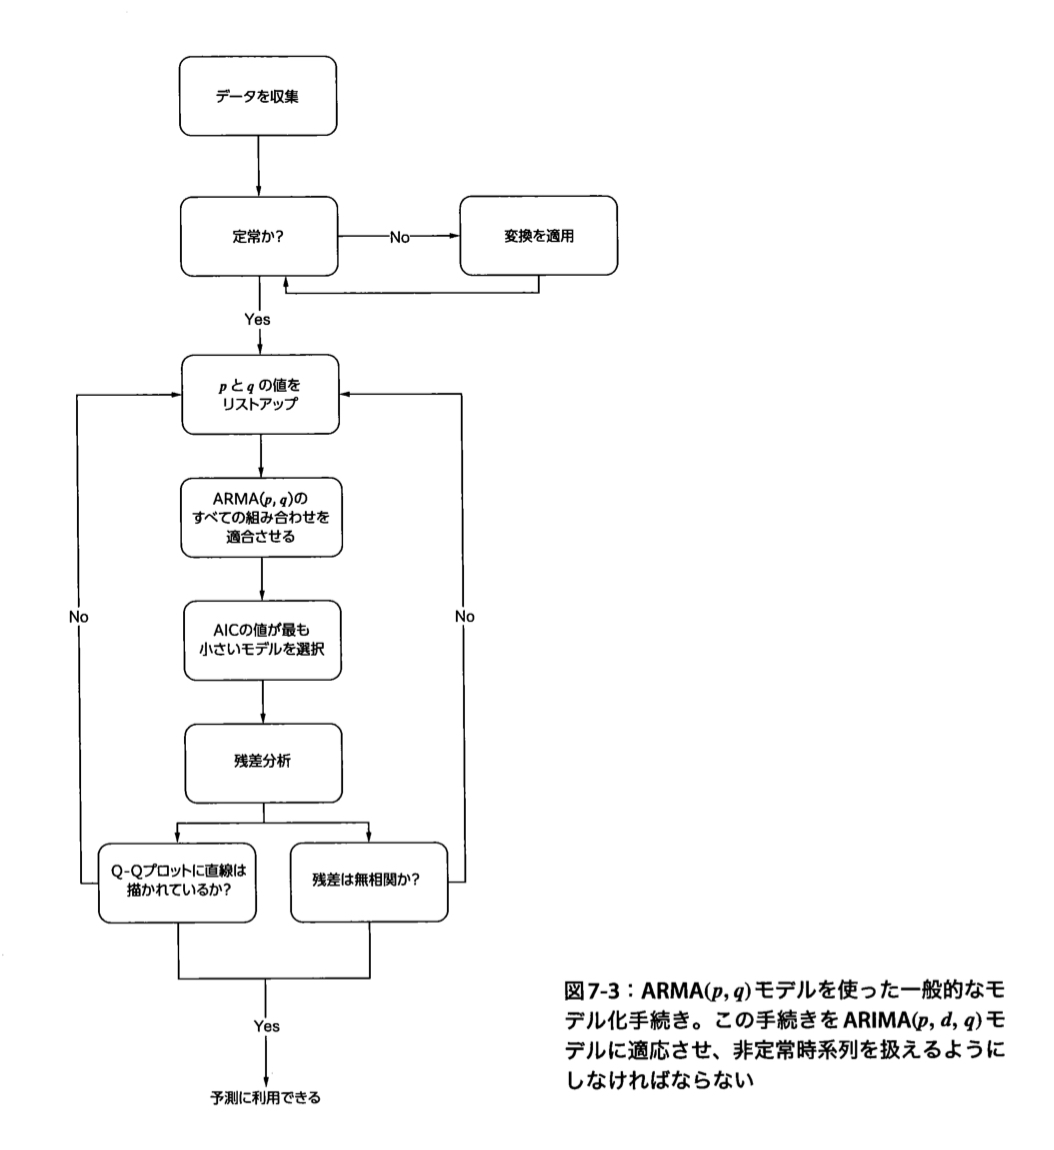

# **7.1　自己回帰和分移動平均(ARIMA)プロセスを定義する**

自己回帰和分移動平均プロセスは、

　　自己回帰プロセス AR(p)

　　和分 I(d)

　　移動平均プロセス MA(q)
  
の組み合わせである。

ARMAプロセス同様に、ARIMAプロセスでも、現在の値が過去の値(AR(p)の部分)と過去の誤差(MA(q)の部分)に依存する。

一方で、ARIMAプロセスでは$y_t$で表される元の時系列ではなく、$y'_t$で表される差分を取った時系列を用いる。

これによって、予測値を逆変換するという手順が必要なくなる。

ARIMA(p, d, q)プロセスの一般的な式は、次のようになる。

　**$y'_t$ = *C* + $\phi_1$$y'_{t-1}$ + ・・・ +$\phi_p$$y'_{t-p}$ + $θ_1$$ε’_{t-1}$ + ・・・ + $θ_q$$ε'_{t-p}$ + $ε_t$**

ただし、この式には次数dは含まれない。

また、ラグ演算子を用いたARIMA過程の定義として、

　$\phi(L) y^{(d)}(t) = C + θ(L)ε_t$

　$\phi(L) (1-L)^d y(t) = C + θ(L)ε_t$

ここで、次数dは **和分次数** として定義する。(時系列を定常化させるために必要な差分の最小回数)

**一回差分**

$y'_t = y_t - y_{t-1}$

$y_t = y_0 + (y_1 - y_0) + (y_2 - y_1)+ ・・・ +(y_t - y_{t-1})$

$= y_0 + Σ_{s=1}^t y'_s$

$E[y'_s] = μ$　→　$E[y_t]=y_0 + μt$

**二回差分**

$y''_t = y'_t - y'_{t-1}$

$y''_t = y'_0 + (y'_1 - y'_0) + ・・・ + (y'_t - y'_{t-1})$

　= $y'_0 + 𝝨_{s=2}^t y''_s$

$E[y''_s] = μ → E[y'_t] = 0 + μ(t-1)$

　　　　　　$→E[y_t] = y_0 + \frac{t(t-1)μ}{2}$

よって、d回差分化したものが定常　→ 元のデータは $t^d$ で変化する。

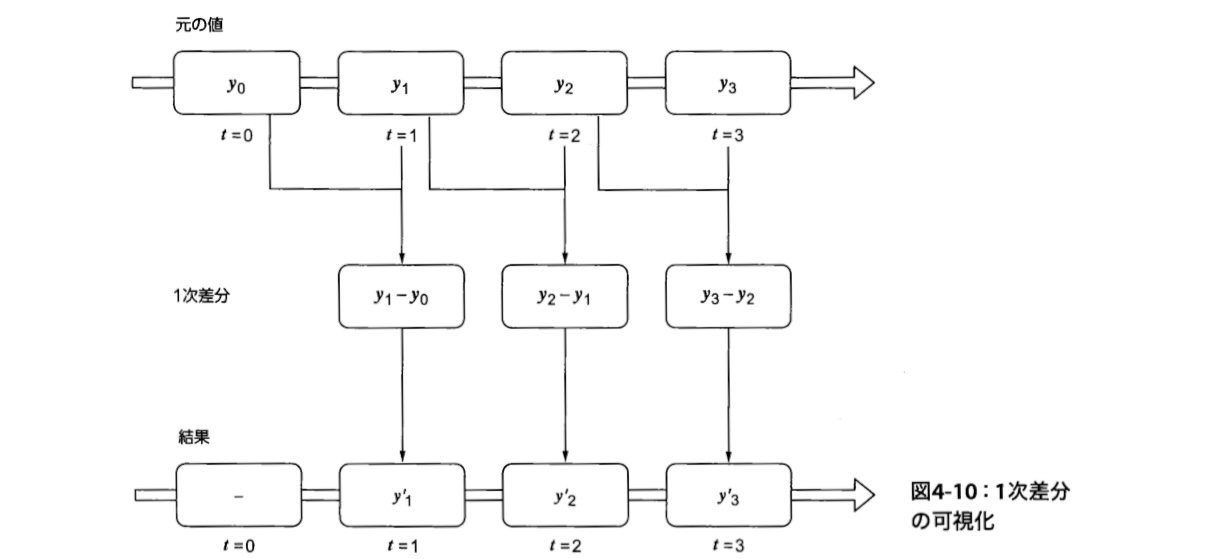

**和分次数**　**＝**　**時系列が定常になるまで差分を取った回数**

差分を取ることで定常かできる時系列を**和分時系列**という

ARIMAモデルは、非定常時系列に適用できるARMAモデル。

つまり、ARMAモデルのようにモデルを適合させる前の時系列が定常であることは求められず、非定常時系列にも適用できる。

単に、和分次数dを突き止める必要があるだけである。

# **7.2　非定常時系列を考慮の対象にするために一般的なモデル化手続きを変更する。**

和文次数を決定するステップを追加する。

この時、**過差分**には注意する。　→ かえって予測モデルの性能を下げることにつながる。

ARMA(p, q)モデルの代わりに、ARIMA(p, d, q)モデルを用いる。

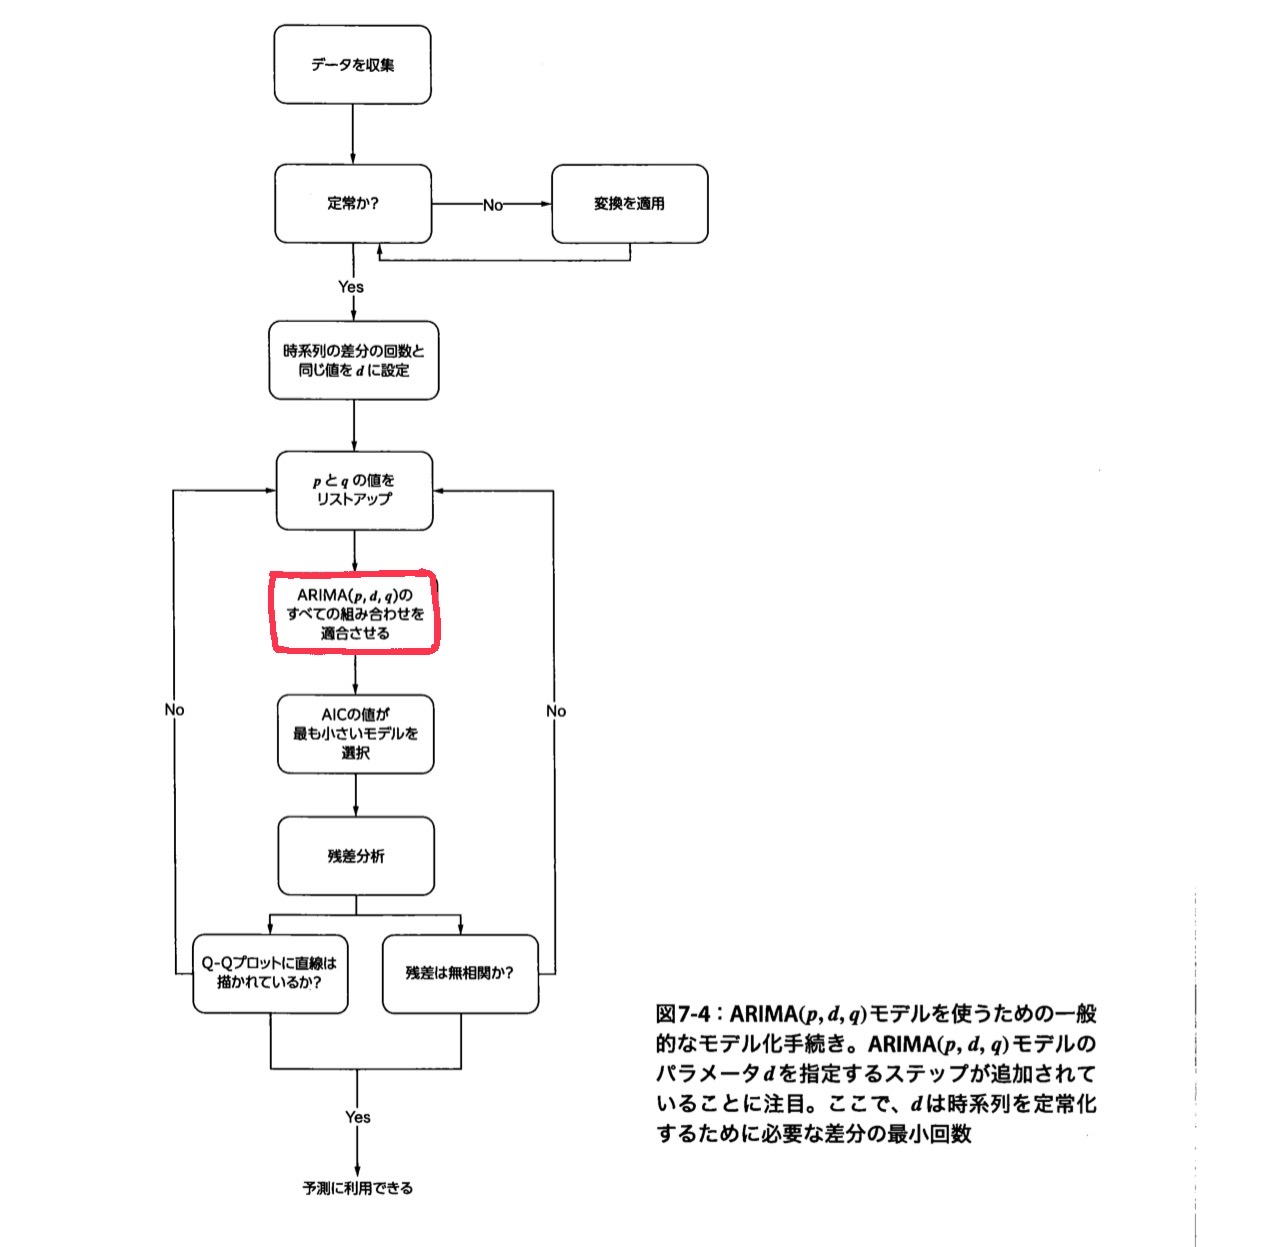

d=0の時は、ARMA(p, q)モデルと同等である。

# **7.3　非定常時系列を予測する。**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
df = pd.read_csv('sample_data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


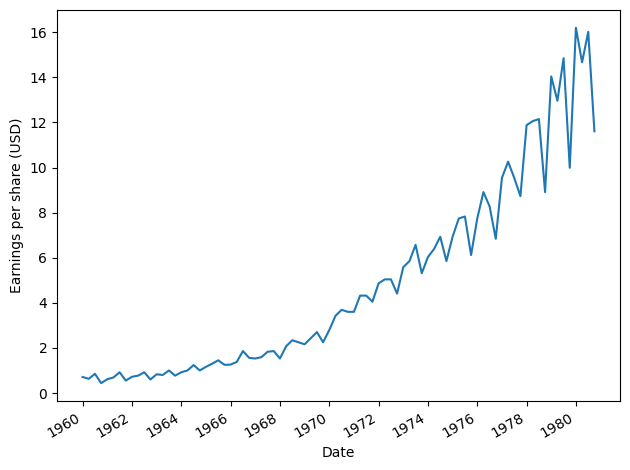

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574744
p-value: 1.0


ADF統計量は2.74で、大きい負の値ではない。

p値は1.0 > 0.05 となり、帰無仮説を棄却できない。

よって、この時系列は定常ではない。

定常化するために、差分を取ってみる。

一次差分を適用し、テストする。

In [ ]:
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305


ADF統計量は-0.407で、大きい負の値ではない。

p値は0.908 > 0.05となり、d=1では帰無仮説を棄却できない。

二次差分を適用し、テストする。

In [ ]:
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793155
p-value: 0.006051099869603682


ADF統計量は-3.5と、大きい負の値である。

p値は0.006 < 0.05となり、帰無仮説を棄却する。

よって、データを定常化させるには、差分を二回取る必要があった。

したがって、和分次数は d=2 となる。

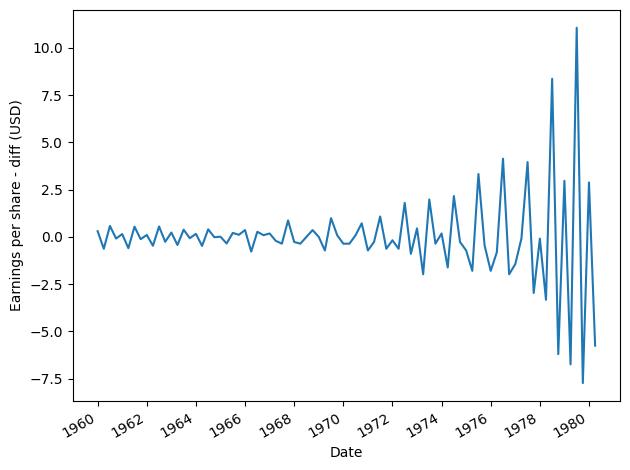

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

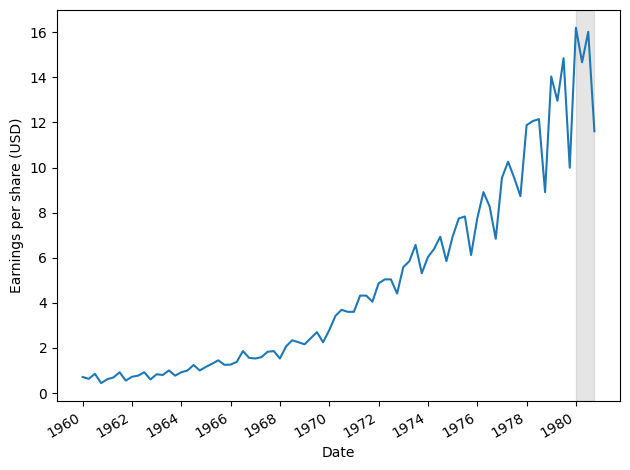

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [ ]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.269418
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430701
4,"(0, 3)",194.654716
5,"(0, 2)",209.274471
6,"(2, 3)",220.667031
7,"(1, 3)",228.267731
8,"(1, 2)",228.935776
9,"(2, 2)",229.974673


返されたDataFrameから、このケースにおいて最適なのは**ARIMA(3, 2, 3)**モデルである。

次に、残差を分析する。

In [ ]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.635
Date:                Tue, 13 May 2025   AIC                            115.269
Time:                        12:55:04   BIC                            131.766
Sample:                             0   HQIC                           121.873
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9993      0.037    -27.093      0.000      -1.072      -0.927
ar.L2         -0.9875      0.040    -24.827      0.000      -1.065      -0.910
ar.L3         -0.9756      0.026    -37.399      0.0

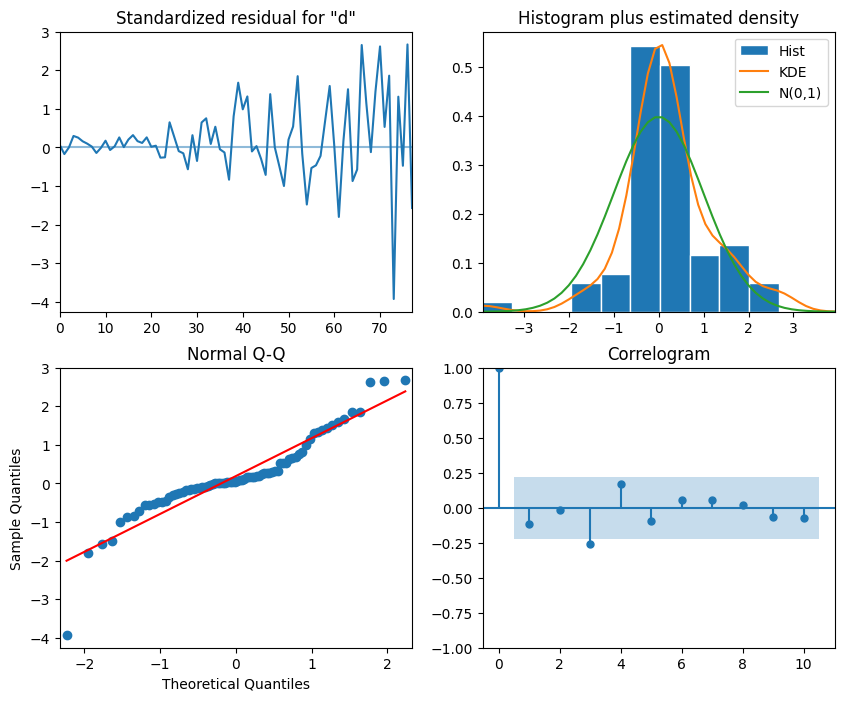

In [ ]:
model_fit.plot_diagnostics(figsize=(10,8));

左上：残差の推移を示す。トレンドはなく、分散も一定には見えない

　　　　→ホワイトノイズでは無さそう。

右上：残差の分布を示す。正規分布に近い。

左下：Q-Qプロット。かなり直線的であり、正規分布に近い。

右下：相関図。ラグ３の係数が有意であるように見えるが、多分偶然。

　　　　→ラグ０の後の有意な係数はない。

したがって、これらの残差はホワイトノイズに近いように見える。(定性的観点)

リュング・ボックス検定を用いて、これらの残差に相関があるかを調べる。(定量的観点)

In [ ]:
results = acorr_ljungbox(residuals, lags=np.arange(1, 11), return_df=True)
pvalue = results['lb_pvalue']

print(pvalue)

1     0.197487
2     0.435292
3     0.063552
4     0.055525
5     0.079447
6     0.120906
7     0.170204
8     0.239903
9     0.295947
10    0.345380
Name: lb_pvalue, dtype: float64


すべてのp値が、0.05より大きいため、帰無仮説は棄却されない。

したがって、これらの残差は無相関であると結論づけられる。

よって、ARIMA(3, 2, 3)モデルは予測に用いることができる。

In [ ]:
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [ ]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.856369
81,1980-04-01,14.67,12.96,14.379503
82,1980-07-02,16.02,14.85,16.368639
83,1980-10-01,11.61,9.99,11.680699


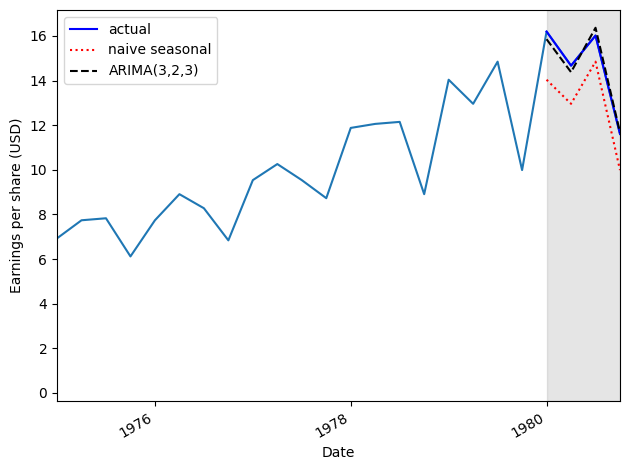

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7216538736432183


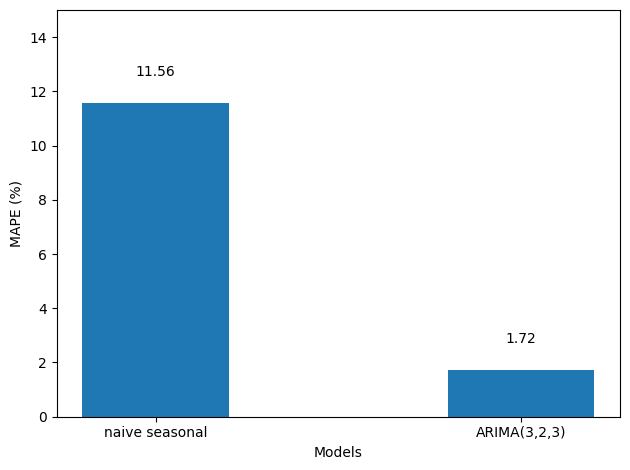

In [ ]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()